In [1]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import new_interf
from datetime import datetime, timedelta
import scipy.optimize
import astropy.constants as c
import astropy.units as u

No module named 'rtlsdr'


In [2]:
sun_data = pd.read_csv('sun_data2.csv')
sun_trunc = sun_data[2100:]
sun_volts = np.array(sun_trunc['Voltages'])
sun_times = np.array(sun_trunc['Times'])

sun_coords = pd.read_csv('sun_coords_times.csv')

RA = np.array(sun_coords['RA'])<<u.rad
Dec = np.array(sun_coords['DEC'])<<u.rad
LST = np.array(sun_coords['LST'])<<u.rad

RA_trunc = RA[2100:]
Dec_trunc = Dec[2100:]
LST_trunc = LST[2100:]

def utc_to_local(unix_time):
    utc_dt = datetime.utcfromtimestamp(unix_time)
    time = utc_dt - timedelta(hours=8)
    tJ= ugradio.timing.julian_date(unix_time)
    return time.strftime('%Y-%m-%d %H:%M:%S'), tJ

t,tJ = utc_to_local(sun_times[0])
lst = pd.read_csv('clean_sun_data.csv')
print(t, "local time", tJ, "Julian time")

sun_times -= sun_times[0]  # this is shorthand for moontime = itself minus moontime[0]
dt = sun_times[1] - sun_times[0]  # this is the time step between samples
sun_volts -= sun_volts.mean()

2022-03-30 10:53:30 local time 2459669.2871537884 Julian time


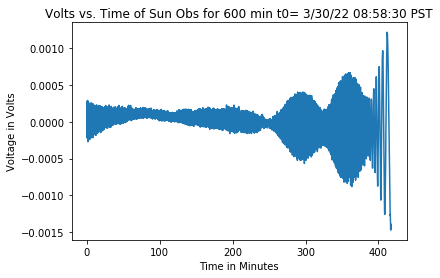

In [3]:
plt.figure()
plt.xlabel("Time in Minutes")
plt.ylabel("Voltage in Volts")
plt.title("Volts vs. Time of Sun Obs for 600 min t0= 3/30/22 08:58:30 PST")
plt.plot(sun_times/60, sun_volts)
plt.show()

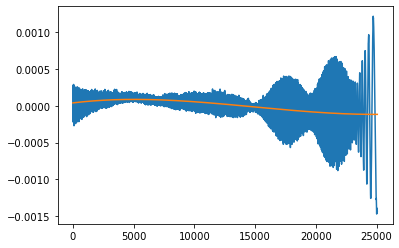

In [4]:
plt.figure()
plt.plot(sun_times, sun_volts)
p = np.polyfit(sun_times, sun_volts, 3)
fit = np.polyval(p, sun_times)
sun_volts-=fit
plt.plot(sun_times, fit)
plt.show()

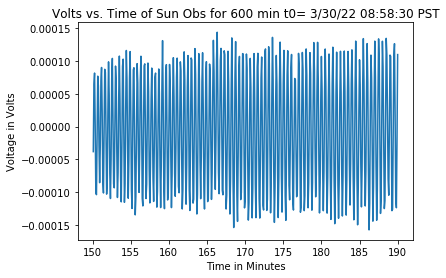

In [5]:
cond = (sun_times/60 > 150) & (sun_times/60 < 190)

plt.figure()
plt.xlabel("Time in Minutes")
plt.ylabel("Voltage in Volts")
plt.title("Volts vs. Time of Sun Obs for 600 min t0= 3/30/22 08:58:30 PST")
plt.plot(sun_times[cond]/60, sun_volts[cond])
plt.show()

In [6]:
# guessing values for nu tau g to fit for the fringe amplitude

#guesses in meters
Bew = 15*u.m
Bns = 1*u.m
L = ugradio.nch.lat # latitude
wl = (c.c/(10.5*u.GHz)).to(u.m)  # wavelength in meters
# ntg = nu tao g
hs = LST_trunc - RA_trunc
ntg = ((Bew / wl *np.cos(Dec_trunc)) * np.sin(hs) + (Bns / wl * np.sin(L)*np.cos(Dec_trunc))*np.cos(hs))
ntg_trunc = ntg[cond]
print(ntg_trunc.min(), ntg_trunc.max())

# now this needs to go into eq 12 (f is a function of A and B)

166.29956704055664 249.94016760485485


In [7]:
F = sun_volts[cond]
def model(n,A,B):
    return A*np.cos(2*np.pi*u.rad*n) + B*np.sin(2*np.pi*u.rad*n) 
    
def chisq(n,A,B):
    stuff = model(n,A,B)
    return np.sum((stuff-F)**2)

popt, pcov = scipy.optimize.curve_fit(model, ntg_trunc, F)
A, B = popt
print(A, B, pcov)

1.3709564846612319e-05 -2.26962422568071e-05 [[3.08328540e-11 6.72500249e-14]
 [6.72500249e-14 3.08223184e-11]]


In [8]:
ntg_smooth = np.linspace(ntg_trunc.min(), ntg_trunc.max(), len(ntg_trunc)*5)

(-0.00015788422742555078, 0.0001442522986661859)

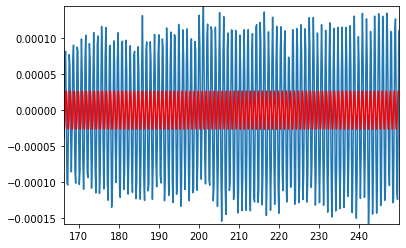

In [9]:
plt.figure()
plt.plot(ntg_trunc, F)
plt.plot(ntg_smooth, model(ntg_smooth, A, B), color='r')
plt.xlim(ntg_trunc.min()-0.01, ntg_trunc.max()+0.01)
plt.ylim(F.min(), F.max())

In [27]:
#guesses in meters
Bew_array = np.linspace(14,16,50)<<u.m
Bns_array = np.linspace(0.5,4.5,50)<<u.m
chisq_array = np.empty((50,50))
i = 0
j = 0

for i, Bew in enumerate(Bew_array):
    for j, Bns in enumerate(Bns_array):
        ntg = (Bew / wl *np.cos(Dec_trunc)) * np.sin(hs) + (Bns / wl * np.sin(L)*np.cos(Dec_trunc))*np.cos(hs)
        ntg_trunc = ntg[cond]

        popt, pcov = scipy.optimize.curve_fit(model, ntg_trunc, F)
        A, B = popt
        #print(i, j)
        chisq_array[i,j] = chisq(ntg_trunc,A,B)

In [28]:
#guesses in meters
Bew_array2 = np.linspace(14.5,15,50)<<u.m
Bns_array2 = np.linspace(0.5,4.5,50)<<u.m
chisq_array2 = np.empty((50,50))
i2 = 0
j2 = 0

for i2, Bew in enumerate(Bew_array2):
    for j2, Bns in enumerate(Bns_array2):
        ntg2 = (Bew / wl *np.cos(Dec_trunc)) * np.sin(hs) + (Bns / wl * np.sin(L)*np.cos(Dec_trunc))*np.cos(hs)
        ntg_trunc2 = ntg2[cond]

        popt2, pcov2 = scipy.optimize.curve_fit(model, ntg_trunc2, F)
        A2, B2 = popt
        #print(i, j)
        chisq_array2[i,j] = chisq(ntg_trunc2,A2,B2)

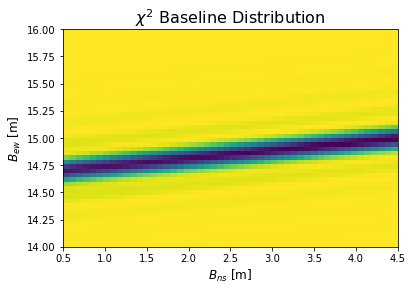

In [39]:
plt.figure()
plt.imshow(chisq_array, extent = [Bns_array.value.min(),Bns_array.value.max(), Bew_array.value.min(),Bew_array.value.max()],
                        aspect='auto', origin='lower')
#cmap_1 = axes[1].imshow(chisq_array2, extent = [Bns_array2.value.min(),Bns_array2.value.max(), Bew_array2.value.min(),Bew_array2.value.max()],
                        #aspect = 'auto', origin = 'lower')
fig.colorbar(cmap_0, ax=axes[0])
#fig.colorbar(cmap_1, ax=axes[1])
plt.title(r'$\chi^2$ Baseline Distribution', fontsize=16)
plt.ylabel(r'$B_{ew}$ [m]', fontsize=12)
plt.xlabel(r'$B_{ns}$ [m]', fontsize=12)
plt.show()
#extent = [Bns_array.value.min(),Bns_array.value.max(), Bew_array.value.min(),Bew_array.value.max()]
#extent = [Bns_array.value.min(), Bns_array.value.max(), Bew_array.value.min(),Bew_array.value.max()],

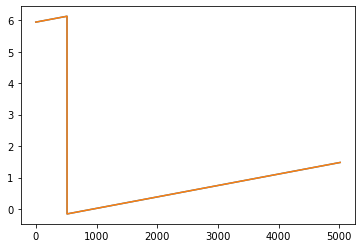

In [12]:
plt.plot(LST[2100:]-RA[2100:])
plt.plot(hs)

In [13]:
RA

<Quantity [0.15428149, 0.1542824 , 0.15428332, ..., 0.16082338, 0.1608243 ,
           0.16082522] rad>

In [14]:
np.argmin(chisq_array)

1247

In [15]:
np.unravel_index(1247,(50,50))

(24, 47)

In [16]:
Bew_array[24],Bns_array[47]

(<Quantity 14.97959184 m>, <Quantity 4.33673469 m>)

In [17]:
hs

<Quantity [5.93947408, 5.93983776, 5.94020145, ..., 1.4783538 , 1.47871748,
           1.47908117] rad>

In [18]:
hs = np.where(hs.value>5,hs - 2*np.pi*u.rad,hs)

In [19]:
np.cos(hs)

<Quantity [0.94151053, 0.94163302, 0.94175539, ..., 0.09231092, 0.09194878,
           0.09158663]>

In [20]:
def bessel_model(ha,theta,A):
    u = Bew_array[24]*np.cos(Dec[0])*np.cos(ha)/wl
    x = 2*np.pi*theta*u
    return np.abs(A*scipy.special.j1(x)/x)

In [21]:
par, cov = scipy.optimize.curve_fit(bessel_model,hs,np.abs(sun_volts),p0=[0.25*np.pi/180,.0005])

In [22]:
theta, A = par
bessel_fit = bessel_model(hs,theta,A)

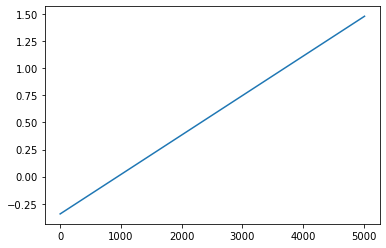

In [23]:
plt.plot(hs)

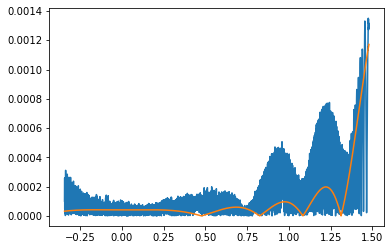

In [24]:
plt.figure()
plt.plot(hs, np.abs(sun_volts))
plt.plot(hs, bessel_fit)
plt.show()

In [25]:
def freq(arr,dt):
    return (np.fft.fftfreq(len(arr),dt))

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


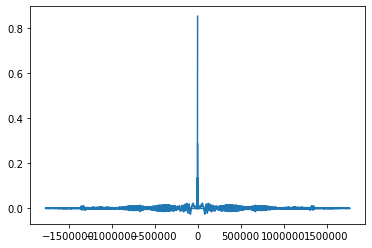

In [26]:
fft = np.fft.fft(np.abs(sun_volts))
freqs = freq(sun_volts, np.mean(np.diff(sun_volts)))
plt.plot(freqs,fft)
plt.show()

In [27]:
fft[0] = 0
cond = np.abs(freqs) > 30000
fft[cond] = 0

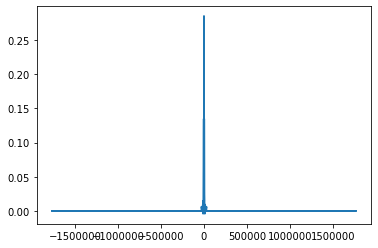

In [28]:
plt.plot(freqs,fft)
plt.show()

In [29]:
filtered_signal = np.fft.ifft(fft)

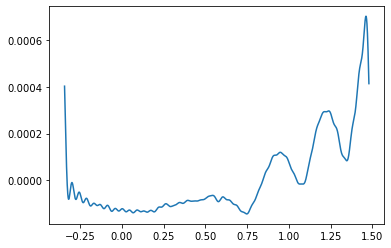

In [30]:
plt.figure()
plt.plot(hs, filtered_signal)
#plt.plot(hs, bessel_fit)
plt.show()

In [31]:
hs_max = hs[np.argmax(filtered_signal)]

In [32]:
cond2 = hs < hs_max 
cond3 = hs > 0.25*u.rad
cond4 = cond2*cond3
filtered_signal_trunc = filtered_signal[cond4]
hs_trunc = hs[cond4]

In [33]:
def bessel_model(ha,theta,A):
    #u = Bew_array[21]*np.cos(Dec[0])*np.cos(ha)/wl
    u = np.sqrt(Bew_array[21]**2 + Bns_array[3]**2)*np.cos(Dec[0])*np.cos(ha)/wl 
    x = 2*np.pi*theta*u
    return np.abs(A*scipy.special.j1(x)/x)

par, cov = scipy.optimize.curve_fit(bessel_model, hs_trunc,filtered_signal_trunc.real, p0=[.25*np.pi/180,.002])
theta, A = par
bessel_fit = bessel_model(hs_trunc,theta,A)
print(theta, A)
#print(.25*np.pi/180)
print(np.sqrt(np.diag(cov)))

0.004514729699185319 0.0019058881153644494
[2.01509887e-05 2.71718305e-05]


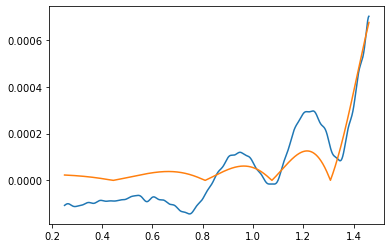

In [34]:
plt.figure()
plt.plot(hs_trunc, filtered_signal_trunc)
plt.plot(hs_trunc, bessel_fit)
plt.show()

In [35]:
u_0 = np.sqrt(Bew_array[19]**2 + Bns_array[1]**2)*np.cos(Dec[0])*np.cos(hs_trunc)/wl
x = 2*np.pi*(.25/180)*u_0
print(u_0)

[500.66797027 500.62140617 500.57477624 ...  56.86381369  56.67701531
  56.49020642]


In [35]:
np.cos(Dec[0])

<Quantity 0.92035551>

In [38]:
np.cos(hs_trunc).max()

<Quantity -0.21079942>

In [39]:
RA

<Quantity [4.91312116, 4.91312227, 4.91312338, ..., 4.92104629, 4.9210474 ,
           4.92104851] rad>

In [40]:
LST

<Quantity [5.89881367, 5.89917558, 5.89954019, ..., 2.20797285, 2.20833746,
           2.20870206] rad>